# Getting Started guide for Anytime MA-BBOB Competition

This notebook is designed to guide you through the process of creating a submission for the GECCO competition on anytime algorithms for MA-BBOB. 
While this competition is built on the IOHprofiler suite, no prior knowledge of these tools is required. This notebook is standalone, so it will explain only the parts required for running and evaluating your algorithm. For more details on IOHprofiler, we refer to iohprofiler.github.io

This notebook is structured as follows:
- Installing the required dependencies
- Accessing the MA-BBOB problems
- Implementing your algorithm
- Logging performance data
- Analyzing the performance of your algorithms
- Comparing your algorithm to the provided baselines


## Step 1: Installing the required packages

For accessing the MA-BBOB generator, we need the IOHexperimenter package, available on pypi as 'ioh'. 

For the later processing of the benchmark data, we will use the newly released IOHinspector package. This can be cloned and installed from GitHub directly, or installed as 'iohinspector' from pypi.

We will now load these packages, as well as some default packages which we will use for the example algorithm

In [1]:
import iohinspector
import ioh
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm # optional, for progress bars
import os

## Step 2: Accessing the MA-BBOB problems

To access the MA-BBOB problems themselves, we use the IOHexperimenter. This can be done via `ioh.problem.ManyAffine`, which can either be instantiated using an instance number and problem dimensionality, or, for more direct control of the affine combination, using the location of the optimum, weigthing of the BBOB problems and their corresponding instances and finally the problem dimensionality. 

To allow for easy comparison with our baselines, we will use the provided files with full instance specifications, rather than the instance number approach. 

In [2]:
# Read in the instance specifications
weights = pd.read_csv("weights.csv", index_col=0)
iids = pd.read_csv("iids.csv", index_col=0)
opt_locs = pd.read_csv("opt_locs.csv", index_col=0)
print(len(iids))

1000


To illustrate the functionality of the returned problem, we start by creating the first instances of the problem in 2D. 

In [3]:
f = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[0])[:2], 
                                    weights = np.array(weights.iloc[0]),
                                    instances = np.array(iids.iloc[0], dtype=int), 
                                    n_variables = 2)

With this problem object, your algorithm can access important meta-data, such as the bounds and dimensionality 

In [4]:
f.bounds.lb, f.bounds.ub, f.meta_data.n_variables

(array([-5., -5.]), array([5., 5.]), 2)

For convenient processing / grouping, meta-data can also be modified after the problem has been loaded. This allows for example for the setting of custom problem and instance identifiers.

In [5]:
f.set_id(123)
f.set_instance(1)

## Step 3: Implementing your algorithm

To use IOHexperimenter-based problems, there are no real requirements on your algorithm, since the problem behaves just like a normal python function, returning the function value when called with a candidate solution. Here, we implement a simple random search to illustrate how your algorithm can benefit from the meta-data provided by the problem.

In [6]:
class RandomSearch:
    'Simple random search algorithm'
    def __init__(self, budget_factor: int):
        self.budget_factor: int = budget_factor
        
    def __call__(self, problem: ioh.problem.RealSingleObjective) -> None:
        'Evaluate the problem `budget_factor * DIM` times with a randomly generated solution'
        
        for _ in range(self.budget_factor * problem.meta_data.n_variables):
            # We can use the problems bounds accessor to get information about the problem bounds
            x = np.random.uniform(problem.bounds.lb, problem.bounds.ub)            
            problem(x)   

In [7]:
import numpy as np


class ERADS_QuantumFluxUltraRefined:
    def __init__(
        self,
        budget_factor: int,
        dim=5,
        population_size=50,
        F_init=0.55,
        F_end=0.85,
        CR=0.95,
        memory_factor=0.3,
    ):
        self.budget = budget_factor * dim
        self.population_size = population_size
        self.F_init = F_init  # Initial scaling factor for mutation
        self.F_end = F_end  # Final scaling factor for mutation, adjusting over time
        self.CR = CR  # Crossover probability
        self.dimension = dim
        self.bounds = (-5.0, 5.0)  # Search space bounds
        self.memory_factor = memory_factor  # Memory factor to guide mutation based on past successful steps

    def __call__(self, func):
        # Initialize population uniformly within the bounds
        population = np.random.uniform(
            self.bounds[0], self.bounds[1], (self.population_size, self.dimension)
        )
        fitness = np.array([func(ind) for ind in population])
        best_index = np.argmin(fitness)
        self.f_opt = fitness[best_index]
        self.x_opt = population[best_index]
        evaluations = self.population_size
        memory = np.zeros(
            self.dimension
        )  # Initialize memory to store successful mutation directions

        while evaluations < self.budget:
            # Linear adaptation of the scaling factor over the course of optimization
            F_current = self.F_init + (self.F_end - self.F_init) * (
                evaluations / self.budget
            )

            for i in range(self.population_size):
                # Selection of three distinct random population indices different from current index i
                indices = np.random.choice(
                    [j for j in range(self.population_size) if j != i], 3, replace=False
                )
                x1, x2, x3 = population[indices]
                best = population[best_index]

                # Creation of the mutant vector incorporating memory of past successful mutations
                mutant = x1 + F_current * (
                    best - x1 + x2 - x3 + self.memory_factor * memory
                )
                mutant = np.clip(
                    mutant, self.bounds[0], self.bounds[1]
                )  # Ensure mutant remains within bounds

                # Crossover operation to generate trial vector
                trial = np.where(
                    np.random.rand(self.dimension) < self.CR, mutant, population[i]
                )
                f_trial = func(trial)
                evaluations += 1

                # Selection: Replace the old vector if the trial vector has better fitness
                if f_trial < fitness[i]:
                    population[i] = trial
                    fitness[i] = f_trial
                    if f_trial < self.f_opt:
                        self.f_opt = f_trial
                        self.x_opt = trial
                        best_index = i  # Update the index of the best solution found

                    # Update memory with the successful mutation direction scaled by F_current
                    memory = (
                        1 - self.memory_factor
                    ) * memory + self.memory_factor * F_current * (
                        mutant - population[i]
                    )

                if evaluations >= self.budget:
                    break

        return self.f_opt, self.x_opt


In [8]:


config = {'archive_prob': 0.2079936761167, 'archive_size': 17, 'cauchy_prob': 0.0369235968885, 'cauchy_scale': 0.0477448721342, 'cma_decay': 0.8402236627992, 'cr': 0.8258784307474, 'cr_adapt': False, 'f': 0.457700046307, 'f_adapt': True, 'initial_step_size': 0.3425415050515, 'learning_rate': 0.0361814273267, 'ortho_rate': 0.0348856611909, 'pop_size': 10, 'step_size_adapt': False}

class AdaptiveDE_Ortho_CMA_Cauchy_StepSize:
    def __init__(self, budget=10000, dim=10, pop_size=50, archive_size=10, cr=0.5, f=0.7, ortho_rate=0.1,
                 archive_prob=0.1, learning_rate=0.1, cma_decay=0.9, cauchy_prob=0.1, cauchy_scale=0.1,
                 cr_adapt=True, f_adapt=True, step_size_adapt=True, initial_step_size=0.1):
        self.budget = budget
        self.dim = dim
        self.pop_size = pop_size
        self.archive_size = archive_size
        self.cr = cr
        self.f = f
        self.ortho_rate = ortho_rate
        self.archive_prob = archive_prob
        self.learning_rate = learning_rate
        self.cma_decay = cma_decay
        self.cauchy_prob = cauchy_prob
        self.cauchy_scale = cauchy_scale
        self.cr_adapt = cr_adapt
        self.f_adapt = f_adapt
        self.step_size_adapt = step_size_adapt
        self.initial_step_size = initial_step_size
        self.step_size = initial_step_size  # Initialize step size
        self.population = None
        self.fitness = None
        self.archive = []
        self.mean = None
        self.C = None
        self.cr_history = []
        self.f_history = []
        self.success_history = []  # Track successful steps for step size adaptation

    def __orthogonal_design(self, n):
        if n == 2:
            return np.array([[1, 1], [1, -1]])
        elif n == 4:
            return np.array([[1, 1, 1, 1], [1, -1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1]])
        elif n == 8:
            hadamard_2 = self.__orthogonal_design(2)
            hadamard_4 = self.__orthogonal_design(4)
            return np.kron(hadamard_4, hadamard_2)
        return None

    def __call__(self, func):
        self.f_opt = np.Inf
        self.x_opt = None
        self.population = np.random.uniform(func.bounds.lb, func.bounds.ub, size=(self.pop_size, self.dim))
        self.fitness = np.array([func(x) for x in self.population])
        self.archive = []
        self.mean = np.mean(self.population, axis=0)
        self.C = np.eye(self.dim)
        evals = self.pop_size

        while evals < self.budget:
            for i in range(self.pop_size):
                if evals >= self.budget:
                    break

                # Mutation: Combined Cauchy and Gaussian
                if np.random.rand() < self.cauchy_prob:
                    # Cauchy mutation
                    mutant = self.population[i] + self.cauchy_scale * np.random.standard_cauchy(size=self.dim)
                else:
                    # Gaussian mutation
                    mutant = self.population[i] + self.f * np.random.multivariate_normal(np.zeros(self.dim), self.C)
                mutant = np.clip(mutant, func.bounds.lb, func.bounds.ub)

                # Archive interaction
                if len(self.archive) > 0 and np.random.rand() < self.archive_prob:
                    arc_idx = np.random.randint(len(self.archive))
                    mutant = self.archive[arc_idx]

                # Crossover
                crossover_mask = np.random.rand(self.dim) < self.cr
                trial = np.where(crossover_mask, mutant, self.population[i])

                # Orthogonal Crossover based on promising region
                if np.random.rand() < self.ortho_rate:
                    design_size = 2
                    if self.dim >= 4:
                        design_size = 4
                    if self.dim >= 8:
                        design_size = 8
                            
                    hadamard_matrix = self.__orthogonal_design(design_size)

                    if hadamard_matrix is not None:
                        best_index = np.argmin(self.fitness)
                        x_best = self.population[best_index]

                        num_factors = min(design_size, self.dim)
                        selected_indices = np.random.choice(self.dim, num_factors, replace=False)
                        levels = np.array([-1, 1])  # Define levels as -1 and 1
                        factor_levels = np.zeros((design_size, self.dim))

                        for j in range(num_factors):
                            factor_levels[:, selected_indices[j]] = hadamard_matrix[:, j]

                        trial_fitnesses = []
                        trial_vectors = []
                        for row in factor_levels:
                            orthogonal_vector = self.population[i].copy()
                            for k in range(self.dim):
                                if row[k] != 0:
                                    orthogonal_vector[k] = x_best[k] + row[k] * self.step_size * (self.population[i][k] - x_best[k]) # Use step_size
                            orthogonal_vector = np.clip(orthogonal_vector, func.bounds.lb, func.bounds.ub)
                            trial_vectors.append(orthogonal_vector)
                            trial_fitnesses.append(func(orthogonal_vector))
                            evals += 1
                            if evals >= self.budget:
                                break

                        best_index = np.argmin(trial_fitnesses)

                        if trial_fitnesses[best_index] < self.fitness[i]:
                             trial = trial_vectors[best_index].copy()

                # Evaluation
                f_trial = func(trial)
                evals += 1

                if f_trial < self.fitness[i]:
                    # Archive update
                    if len(self.archive) < self.archive_size:
                        self.archive.append(self.population[i].copy())
                    else:
                        idx_to_replace = np.random.randint(len(self.archive))
                        self.archive[idx_to_replace] = self.population[i].copy()
                    
                    # Step size adaptation based on success rate
                    self.success_history.append(1)  # Record success
                    if self.step_size_adapt:
                        # Adjust step size based on recent successes.
                        success_rate = np.mean(self.success_history[-min(len(self.success_history), 10):]) # Average over last 10 successes
                        if success_rate > 0.6:
                            self.step_size *= 1.1  # Increase step size if successful
                        elif success_rate < 0.2:
                            self.step_size *= 0.9  # Decrease step size if not successful
                        self.step_size = np.clip(self.step_size, 0.01, 1.0) #Clip the step size to a reasonable interval

                    # Adaptation of parameters
                    if self.cr_adapt:
                         self.cr_history.append(self.cr)
                         self.cr = np.random.normal(0.5, 0.1)
                         self.cr = np.clip(self.cr, 0.1, 0.9)
                    if self.f_adapt:
                        self.f_history.append(self.f)
                        self.f = np.random.normal(0.7, 0.1)
                        self.f = np.clip(self.f, 0.1, 0.9)

                    # Population update
                    self.population[i] = trial
                    self.fitness[i] = f_trial

                    # Simplified CMA update with rank-one update
                    diff = self.population[i] - self.mean
                    self.C = (self.cma_decay) * self.C + (1 - self.cma_decay) * np.outer(diff, diff)
                    self.mean = np.mean(self.population, axis=0)

                    # Update best solution
                    if f_trial < self.f_opt:
                        self.f_opt = f_trial
                        self.x_opt = trial
                else:
                    self.success_history.append(0)  # Record failure

        return self.f_opt, self.x_opt



## Step 4: Data Collection

To run your algorithm and log the performance data, IOHexperimenter provides a `logger` object. This can be heavily customized, but for the purposes of running your algorithm on the MA-BBOB suite most settings can be kept at their defaults. We only modify the location where the data is stored, the name of the folder and the name of the algorithm we are logging. 

In [9]:
logger = ioh.logger.Analyzer(
        root=os.getcwd(),                  # Store data in the current working directory
        folder_name="AdaptiveDE_Ortho_CMA_Cauchy_StepSize",       # in a folder named: 'RS_Test'
        algorithm_name="AdaptiveDE_Ortho_CMA_Cauchy_StepSize",    # meta-data for the algorithm used to generate these results
    )

With this logger, we can now loop over the required problems (from the instance-data we loaded in step 2) and run our algorithm

In [10]:
for dim in [2,5]: # Dimensionality settings
    for idx in tqdm(range(100)): # Loop over all instances in our data files
        RS = AdaptiveDE_Ortho_CMA_Cauchy_StepSize(budget=2000*dim, dim=dim, **config) 
        f_new = ioh.problem.ManyAffine(xopt = np.array(opt_locs.iloc[idx])[:dim], 
                                    weights = np.array(weights.iloc[idx]),
                                    instances = np.array(iids.iloc[idx], dtype=int), 
                                    n_variables = dim)
        f_new.set_id(100)
        f_new.set_instance(idx)
        f_new.attach_logger(logger)
            
        RS(f_new)
        f_new.reset()
logger.close()

100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


## Step 5: Loading the benchmark data

To process the data from the experiments, we can use the new IOHinspector package, which provides access to a variety of analysis methods in the form of a python package. Of course, the IOHanalyzer webpage can also be used for this purpose.

IOHinspector works by first creating a `DataManager` object, which we then point to the folders we want to include in the analysis. 

In [11]:
manager = iohinspector.DataManager()
manager.add_folder("RS_Test")
manager.add_folder("ERADS_QuantumFluxUltraRefined")
manager.add_folder("AdaptiveHybridDECMASMirroredDecay")
manager.add_folder("AdaptiveDE_Ortho_CMA_Cauchy_StepSize")

This object keeps track of the meta-data, and can be used to e.g. filter data before loading the underlying performance files into memory.

In [12]:
manager.overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y
u64,str,str,str,str,u16,u16,u16,u32,u64,f64
601,"""AdaptiveDE_Ortho_CMA_Cauchy_St…","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,0,1,4000,7.7390e-9
602,"""AdaptiveDE_Ortho_CMA_Cauchy_St…","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,1,2,4000,4.2800e-12
603,"""AdaptiveDE_Ortho_CMA_Cauchy_St…","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,2,3,4000,3.9163e-11
604,"""AdaptiveDE_Ortho_CMA_Cauchy_St…","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,3,4,4000,3.2690e-12
605,"""AdaptiveDE_Ortho_CMA_Cauchy_St…","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,2,4,5,4000,6.4048e-12
…,…,…,…,…,…,…,…,…,…,…
196,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,95,96,10000,0.033516
197,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,96,97,10000,1.540569
198,"""RandomSearch""","""algorithm_info""","""unknown_suite""","""ManyAffine""",100,5,97,98,10000,1.053326


Loading the data can be done using the `load` functionality. This has the option to make the data monotonic (e.g. extract the best-so-far as the performance measure) and to include the meta-data into the resulting dataframe for convenient aggregation in plots. 

In [13]:
df = manager.load(True, True)

With this dataframe, the rest of the iohinspector can be used to analyze the optimization behavior. For example, we can filter out the 2-dimensional data and plot a basic ECDF of our random search algorithm as follows:

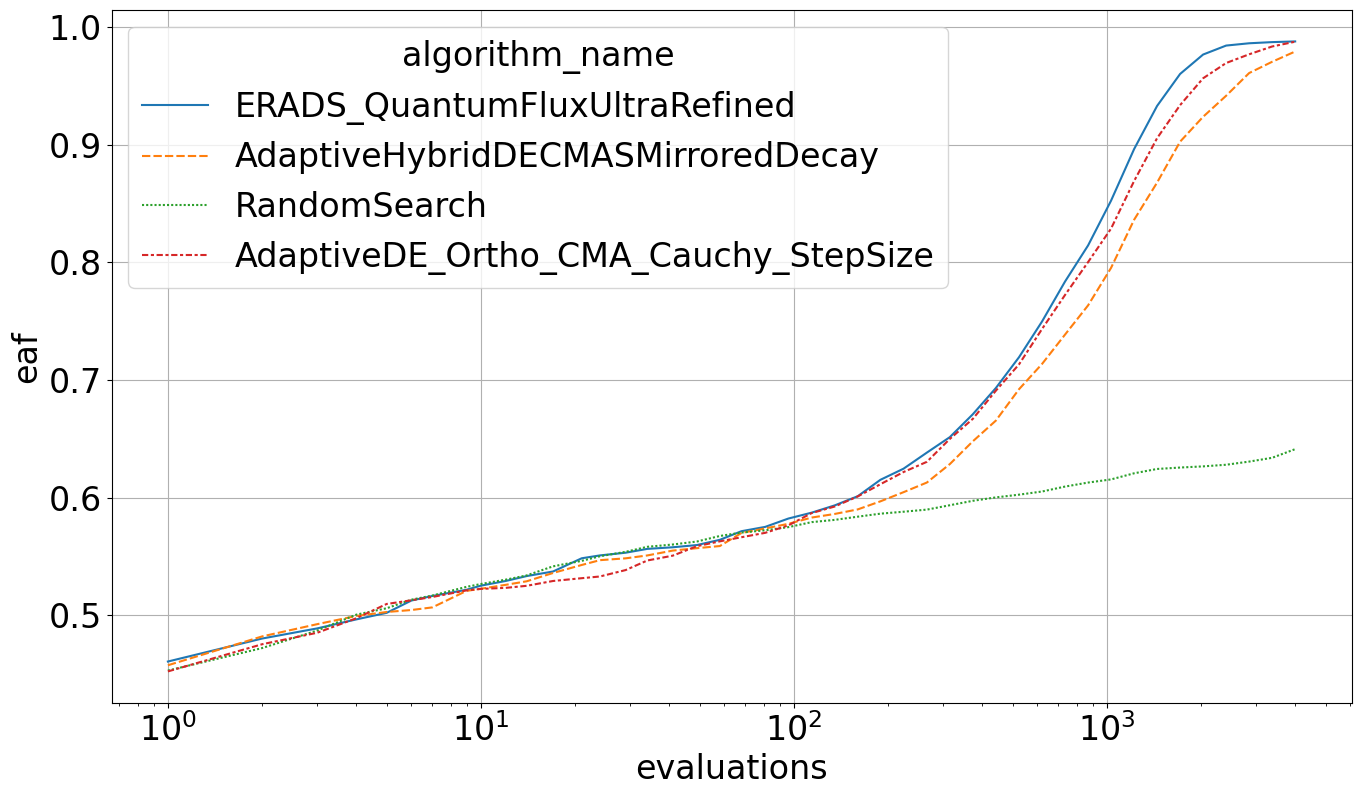

In [14]:
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 2), y_max=100, y_min=1e-8)

For the competition, the performance is judged based on the Area Over the Convergence Curve metric (which is equivalent to the area under the ECDF above). Specifically, we use bounds 10^2 and 10^-8. 

In [15]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 2), 4000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""RandomSearch""",0.393654
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.823156
"""ERADS_QuantumFluxUltraRefined""",0.842472
"""AdaptiveHybridDECMASMirroredDe…",0.785066


## Step 6: Comparing to baselines

For this competition, we provide a set of baseline algorithm data, which consist of 5 algorithms with 50 independent runs on each problem. This data can be loaded from https://doi.org/10.5281/zenodo.8208572 (`data.zip`) and incorporated into the IOHinspector analysis as usual. 

Note: since the baseline data contains a large amount of runs, processing it fully can take some time

In [16]:
manager_comp = iohinspector.DataManager()
manager_comp.add_folder("RS_Test")
manager_comp.add_folder("ERADS_QuantumFluxUltraRefined")
manager_comp.add_folder("MABBOB_Baselines")
manager_comp.add_folder("AdaptiveHybridDECMASMirroredDecay")
manager_comp.add_folder("AdaptiveDE_Ortho_CMA_Cauchy_StepSize")

In [17]:
df = manager_comp.load(True, True, ['dimension', 'algorithm_name', 'instance'])
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
res_2d = iohinspector.metrics.get_aocc(df_eaf, 2*2000, group_cols=['algorithm_name'])
res_2d

algorithm_name,AOCC
str,f64
"""RandomSearch""",0.320005
"""AdaptiveHybridDECMASMirroredDe…",0.631602
"""ERADS_QuantumFluxUltraRefined""",0.728243
"""PSS""",0.506898
"""ACA""",0.393659
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.69079


In [18]:
res_5d = iohinspector.metrics.get_aocc(df_eaf, 5*2000, group_cols=['algorithm_name'])
res_5d

algorithm_name,AOCC
str,f64
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.814422
"""PSS""",0.558821
"""RandomSearch""",0.336434
"""AdaptiveHybridDECMASMirroredDe…",0.768579
"""ERADS_QuantumFluxUltraRefined""",0.837076
"""ACA""",0.418788


In [19]:
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 2), 4000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""AdaptiveHybridDECMASMirroredDe…",0.785066
"""RandomSearch""",0.393654
"""ACA""",0.482176
"""ERADS_QuantumFluxUltraRefined""",0.837459
"""PSS""",0.60194
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.823156


In [20]:
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])

algorithm_name,AOCC
str,f64
"""ACA""",0.327829
"""AdaptiveDE_Ortho_CMA_Cauchy_St…",0.711613
"""RandomSearch""",0.259947
"""PSS""",0.511605
"""ERADS_QuantumFluxUltraRefined""",0.752081
"""AdaptiveHybridDECMASMirroredDe…",0.643158
